In [1]:
#Import the necessary pacakges 
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as Data
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math 
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(-1, 1))

In [2]:
##A function to download the stock price data. 
SYMBOLS = ["AAPL", "MSFT", "AMZN", "META", "GOOGL", "GOOG", "BRK-B", "TSLA", "NVDA", "JPM"]
def format_dataset():
    all_stocks_data = []
    prices = yf.download(SYMBOLS, start=START, end=END)
    for symbol in SYMBOLS:
        prices.index = prices.index.map(str)
        stock_df = prices.T.loc[(slice(None), symbol), :].swaplevel(i=0, j=1).xs(symbol, level=0).T.dropna(how="all")
        stock_df["symbol"] = symbol
        stock_df["date"] = pd.to_datetime(stock_df.index)
        stock_df["price"] = stock_df["Adj Close"]
        all_stocks_data.append(stock_df[["symbol", "date", "price"]].reset_index(drop=True))
    combined = pd.concat(all_stocks_data)
    combined.to_csv("data.csv")

In [3]:
##Create the LSTM model
class LSTM(nn.Module):
    def __init__(self, hidden_size, num_layers):
        super(LSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        #Define the LSTM model
        self.LSTM = nn.LSTM(
            input_size=1,
            hidden_size=self.hidden_size,
            num_layers=self.num_layers,
            batch_first=True
        )
        
        #Define the Linear model to get the ouput. 
        self.linear = nn.Linear(self.hidden_size, 1)
        
        #Define the forward function 
    def forward(self, x):
        # Initialize hidden state with zeros
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).requires_grad_()
        # Initialize cell state
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).requires_grad_()
        # Perform LSTM model. 
        out, (hn, cn) = self.LSTM(x, (h0.detach(), c0.detach()))

        # Index hidden state of last time step
        # out.size() --> batch size, sequence_length, hidden_size
        # out[:, -1, :] --> batch size, 1, hidden_size --> We only need the hidden size of the last time. 
        out = self.linear(out[:, -1, :]) 
        return out

    
    

In [12]:
##Create a file to automatically load dataset and separate the data into train_data and test_data

#Load the datasets.
def load_data(stock_ID, look_back_days):
    dat = pd.read_csv('data.csv')
    price=dat.loc[dat['symbol']== stock_ID]
    price=price.set_index('date')
    price=price.drop(['symbol'], axis=1)
    price['price'] = scaler.fit_transform(price['price'].values.reshape(-1,1))
    #print(price)
    time_cutoff = "2022/9/30"
    time_final = "2022/11/18"
    time_cutoff_loc = price.index.get_loc(time_cutoff)
    time_final_loc = price.index.get_loc(time_final)
    
    #Get the days for prediction
    pred_days = price.index[(time_cutoff_loc + 1):(time_final_loc + 1)].to_numpy()

    #Split the data into train and test. 
    train_price=price['price'].iloc[:time_cutoff_loc + 1]
    test_price = price['price'].iloc[(time_cutoff_loc - look_back_days + 1):(time_final_loc + 1)]

    
    ##Get the x_train and y_train dataset
    x_train = []
    y_train = []
    for index in range(len(train_price) - look_back_days): 
        x_train.append(train_price.iloc[index: index + look_back_days].to_numpy())
        y_train.append(train_price.iloc[index + look_back_days])

    x_train = torch.FloatTensor(x_train)
    y_train = torch.FloatTensor(y_train)
    x_train = torch.reshape(x_train, (x_train.shape[0], x_train.shape[1],1))
    y_train = torch.reshape(y_train, (y_train.shape[0], 1))


    ##Get the x_test and y_test dataset
    x_test = []
    y_test = []
    for index in range(len(test_price) - look_back_days): 
        x_test.append(test_price.iloc[index: index + look_back_days].to_numpy())
        y_test.append(test_price.iloc[index + look_back_days])

    x_test = torch.FloatTensor(x_test)
    y_test = torch.FloatTensor(y_test)
    x_test = torch.reshape(x_test, (x_test.shape[0], x_test.shape[1],1))
    y_test = torch.reshape(y_test, (y_test.shape[0], 1))
    
    ##combine the x,y into a coplete dataset.
    train_dat = Data.TensorDataset(x_train, y_train)
    test_dat = Data.TensorDataset(x_test, y_test)
    
    return train_dat, test_dat, pred_days

In [13]:
##Define a train function to train the model. 
def model_perf(stock_ID, hidden_size, num_layers, learning_rate, look_back_days, batch_size, epoches = 20):

    model = LSTM(hidden_size, num_layers)       # 3 hyperparameters
    device = "cpu"
    if torch.cuda.is_available():
        device = "cuda:0"
    model.to(device)

    loss_fn = torch.nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr= learning_rate) # Another hyperparameter.

    #Load the dataset. 
    train_dat, test_dat, pred_days = load_data(stock_ID, look_back_days)  #Another hyperparamter. 

    #Split the train dataset into training (80%) and validation (20%). 
    train_Nsamples = int(len(train_dat) * 0.8)
    
    train_subset, val_subset = Data.random_split(
        train_dat, [train_Nsamples, len(train_dat) - train_Nsamples])

    trainloader = Data.DataLoader(
        train_subset,
        batch_size=batch_size,       # Another hyperparameter
        shuffle=True,
        num_workers=8)
    
    valloader = Data.DataLoader(
        val_subset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=8)
    
    print("Started!!!")
    for epoch in range(epoches):  # loop over the dataset multiple times
        running_loss = 0.0
        epoch_steps = 0

        # For loop to train the model.
        for batch_x, batch_y in trainloader:
            
            # zero the parameter gradients
            optimizer.zero_grad()
            
            # forward + backward + optimize
            outputs = model(batch_x)
            loss = loss_fn(outputs, batch_y)
            loss.backward()
            optimizer.step()
            running_loss = loss.item()

        # Validation loss
        val_loss = 0.0
        val_steps = 0
        for batch_x, batch_y in valloader:
            with torch.no_grad():
                outputs = model(batch_x)
                loss = loss_fn(outputs, batch_y)
                val_loss += loss.numpy()
                val_steps += 1
                
        ##Output the performance for each epoch. 
        print("Epoch: %d, Training loss: %.3f, Validation loss: %.3f" % (epoch + 1, running_loss, val_loss/val_steps))
    
    # Test loss 
    testloader = Data.DataLoader(
        test_dat, batch_size=len(test_dat), shuffle=False, num_workers=1)

    #Perform the analysis with all test data. 
    with torch.no_grad():
        for batch_x, batch_y in testloader:
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)
            outputs = model(batch_x)
            loss = loss_fn(outputs, batch_y)
            
            y_test_pred = scaler.inverse_transform(outputs.detach().numpy()).flatten()
            y_test = scaler.inverse_transform(batch_y.detach().numpy()).flatten()
            #print("The true stock prices are: ", y_test)
            #print("The predicted stock prices are: ", y_test_pred)
            RMSE = math.sqrt(mean_squared_error(y_test, y_test_pred))
            MSE = mean_squared_error(y_test,y_test_pred)
            print('Test RMSE: %.4f, MSE: %.4f' % (RMSE, MSE))
    
    ##Create a dataframe for visualization.
    df = pd.DataFrame({"pred_days":pred_days, "True_price": y_test, "Pred_price":y_test_pred}, index = pred_days)
            
    return df, RMSE, MSE


In [18]:
##Define the hyperparamters.
hs = 128
n_layers = 2
lr = 0.01
lb_days = 30
bs = 32
ep = 20
SPY_TOP_10_SYMBOLS = ["AAPL", "MSFT", "AMZN", "META", "GOOGL", "GOOG", "BRK-B", "TSLA", "NVDA", "JPM"]

df_total = []
RMSE_total = []
MSE_total = []

for symbol in SPY_TOP_10_SYMBOLS:
    df, RMSE, MSE = model_perf(stock_ID = symbol, hidden_size = hs, num_layers = n_layers, learning_rate = lr,
                               look_back_days = lb_days, batch_size = bs, epoches= ep)
    df_total.append(df)
    RMSE_total.append(RMSE)
    MSE_total.append(MSE)


Started!!!
Epoch: 1, Training loss: 0.341, Validation loss: 0.129
Epoch: 2, Training loss: 0.238, Validation loss: 0.218
Epoch: 3, Training loss: 0.152, Validation loss: 0.173
Epoch: 4, Training loss: 0.063, Validation loss: 0.145
Epoch: 5, Training loss: 0.128, Validation loss: 0.087
Epoch: 6, Training loss: 0.045, Validation loss: 0.087
Epoch: 7, Training loss: 0.043, Validation loss: 0.050
Epoch: 8, Training loss: 0.023, Validation loss: 0.040
Epoch: 9, Training loss: 0.032, Validation loss: 0.046
Epoch: 10, Training loss: 0.020, Validation loss: 0.043
Epoch: 11, Training loss: 0.018, Validation loss: 0.037
Epoch: 12, Training loss: 0.021, Validation loss: 0.037
Epoch: 13, Training loss: 0.022, Validation loss: 0.033
Epoch: 14, Training loss: 0.028, Validation loss: 0.035
Epoch: 15, Training loss: 0.022, Validation loss: 0.036
Epoch: 16, Training loss: 0.011, Validation loss: 0.033
Epoch: 17, Training loss: 0.030, Validation loss: 0.037
Epoch: 18, Training loss: 0.015, Validation lo

Epoch: 3, Training loss: 0.042, Validation loss: 0.042
Epoch: 4, Training loss: 0.025, Validation loss: 0.041
Epoch: 5, Training loss: 0.017, Validation loss: 0.026
Epoch: 6, Training loss: 0.025, Validation loss: 0.022
Epoch: 7, Training loss: 0.021, Validation loss: 0.017
Epoch: 8, Training loss: 0.010, Validation loss: 0.018
Epoch: 9, Training loss: 0.012, Validation loss: 0.015
Epoch: 10, Training loss: 0.017, Validation loss: 0.015
Epoch: 11, Training loss: 0.012, Validation loss: 0.015
Epoch: 12, Training loss: 0.010, Validation loss: 0.013
Epoch: 13, Training loss: 0.028, Validation loss: 0.013
Epoch: 14, Training loss: 0.019, Validation loss: 0.015
Epoch: 15, Training loss: 0.014, Validation loss: 0.013
Epoch: 16, Training loss: 0.015, Validation loss: 0.013
Epoch: 17, Training loss: 0.006, Validation loss: 0.013
Epoch: 18, Training loss: 0.008, Validation loss: 0.013
Epoch: 19, Training loss: 0.016, Validation loss: 0.012
Epoch: 20, Training loss: 0.010, Validation loss: 0.012

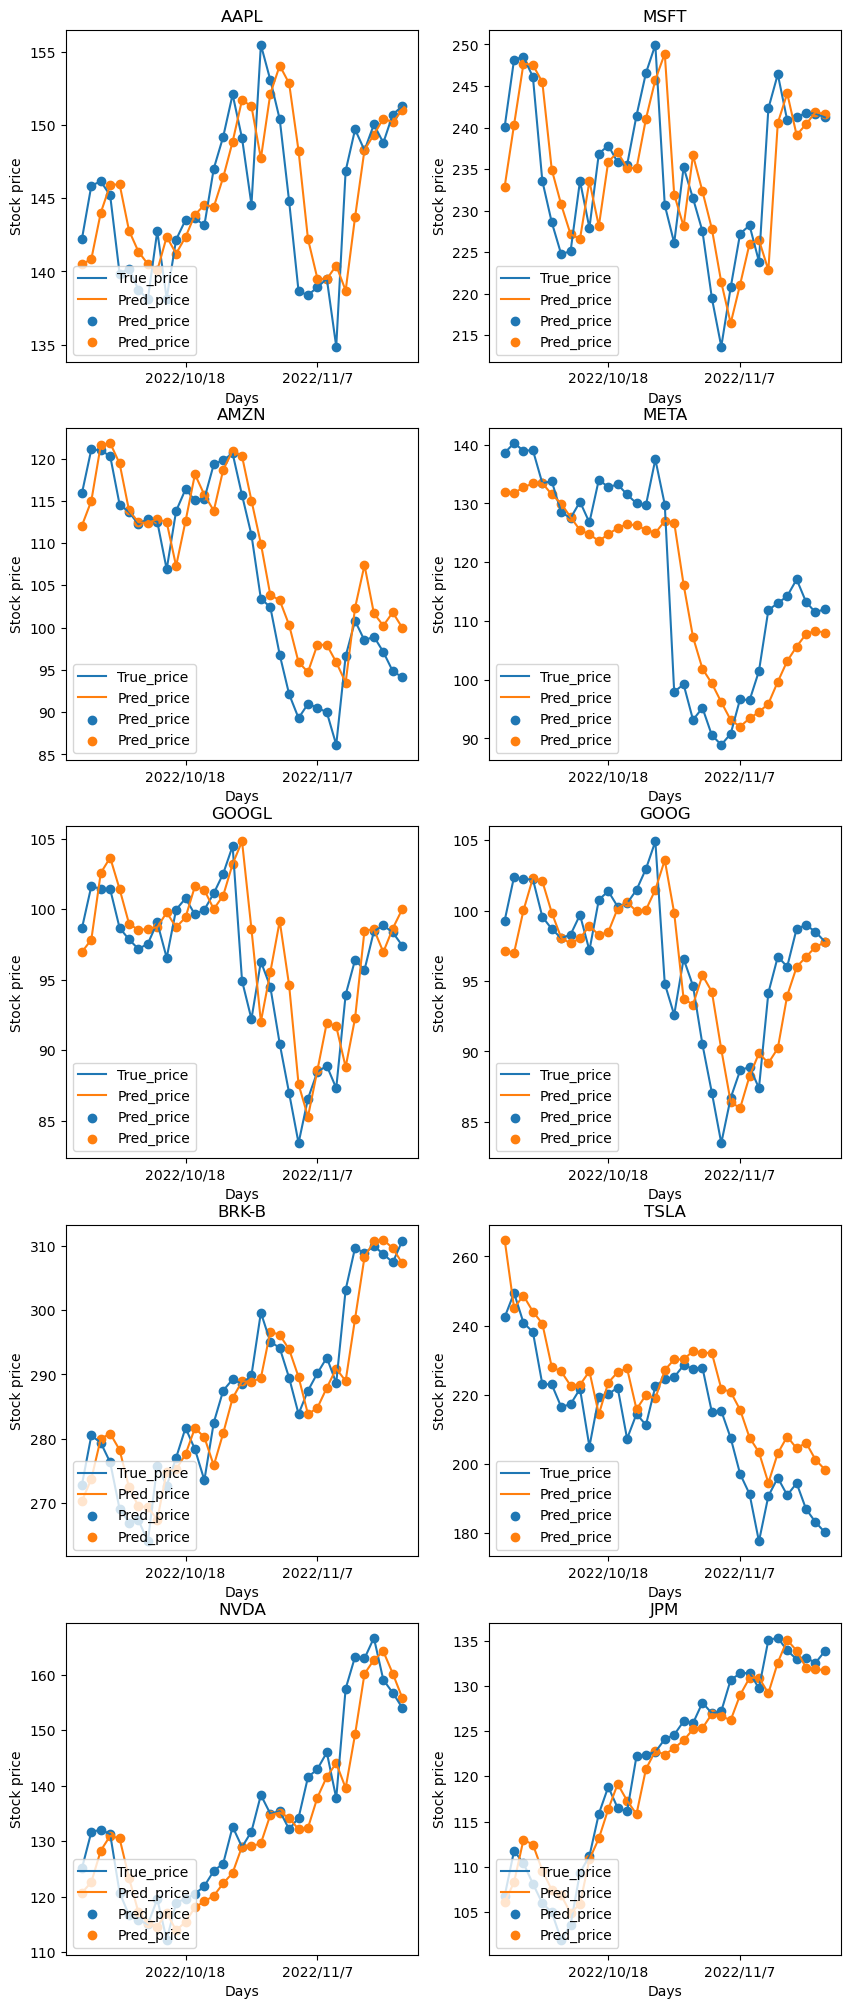

In [19]:
##Visualize the comparison of predicted values against the real values. 
import matplotlib.dates as mdates
from matplotlib.dates import MO, TU, WE, TH, FR, SA, SU
week_locator = mdates.WeekdayLocator(byweekday=MO, interval = 2)

fig = plt.figure(figsize=(10, 25))
for i in range(10):
    fig = plt.subplot(5,2,i+1)
    fig.xaxis.set_major_locator(week_locator)
    df = df_total[i]
    plt.plot(df['True_price'], label = "True_price")
    plt.plot(df['Pred_price'], label = "Pred_price")
    plt.scatter(df['pred_days'], df['True_price'], label = "Pred_price")
    plt.scatter(df['pred_days'], df['Pred_price'], label = "Pred_price")
    plt.xlabel("Days")
    plt.ylabel("Stock price")
    plt.legend(loc='lower left')
    plt.title(SPY_TOP_10_SYMBOLS[i])


In [20]:
##Get a model to assess the MSE, RMSE and MAE for the model prediction (Model prediction error table).
result = pd.DataFrame({'Symbol':SPY_TOP_10_SYMBOLS, 'RMSE':RMSE_total, 'MSE': MSE_total}, index = SPY_TOP_10_SYMBOLS)
print(result)

      Symbol       RMSE         MSE
AAPL    AAPL   4.068921   16.556122
MSFT    MSFT   6.929489   48.017815
AMZN    AMZN   4.963260   24.633945
META    META   9.246835   85.503960
GOOGL  GOOGL   3.626705   13.152990
GOOG    GOOG   3.579325   12.811569
BRK-B  BRK-B   5.477141   29.999075
TSLA    TSLA  12.491905  156.047684
NVDA    NVDA   6.103987   37.258656
JPM      JPM   2.705009    7.317073
